In [29]:
# importing libraries
import pandas as pd
import numpy as np
from pathlib import Path as path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from IPython.display import Image, display
import re
import ast

import warnings
warnings.filterwarnings('ignore')

In [30]:
# paths
home_dir = path.cwd().parent
data_dir = home_dir / 'data'
interim_dir = data_dir / 'interim'

In [31]:
# dataset path
flat_house_data = interim_dir / 'flat-house-dataset.csv'

In [32]:
# reading the dataset
df = pd.read_csv(flat_house_data)

In [33]:
# changing the viewing option
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [34]:
# shape of the dataset
print(f"Shape of the dataset: {df.shape}")

Shape of the dataset: (3793, 17)


In [35]:
# checking rows in the dataset
df.head(1)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
0,flat,umang monsoon breeze,sector 78,0.95,5491.0,1730.0,Built Up area: 1730 (160.72 sq.m.),3.0,3,2,not available,9.0,East,1 to 5 Year Old,"['Proposed Metro Station', 'Mahapal Shing', 'National Highway 8', 'IGD Primary Health Care', 'HDFC Bank', 'PCL Logistics', 'JW Mariott']","['3 Fan', '1 Exhaust Fan', '2 Geyser', '7 Light', '1 Chimney', '1 Modular Kitchen', '3 Wardrobe', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Swimming Pool', 'Park', 'Security Personnel', 'Internet/wi-fi connectivity', 'Fitness Centre / GYM', 'Club house / Community Center', 'Rain Water Harvesting']"


# Features in focus

## 1. areaWithType

In [36]:
# let's check few rows from 'price', 'area', 'areaWithType' columns
df[['price', 'area', 'areaWithType']].sample(5)

,price,area,areaWithType
3635,0.38,549.0,Carpet area: 549.17 (51.02 sq.m.)
1188,2.30,2450.0,Super Built up area 2450(227.61 sq.m.)
1726,1.78,2191.0,Super Built up area 2191(203.55 sq.m.)
816,8.50,4518.0,Plot area 502(419.74 sq.m.)Built Up area: 500 sq.yards (418.06 sq.m.)Carpet area: 400 sq.yards (334.45 sq.m.)
3514,1.00,1110.0,Carpet area: 1110 (103.12 sq.m.)


---
### Initial Obeservations
- as we can see in above 'areawithType' columns
- four types of values are mentioned 
    - carpet area, 
    - built up area, 
    - super built up area and
    - plot area
- carpet area, built area and super built area are belong to flats
- and plot area belong to houses

### Definations

#### Carpet Area:
- `The actual usable area within a property`, excluding walls, balconies, and other common areas.
- Measured from wall to wall, where the carpet could be laid.
- Used for calculating the saleable price per square foot of usable space.

#### Built-Up Area:
- `Carpet area plus the area occupied by walls, balconies, staircases`, etc., within the individual property's boundaries.
- Represents the total area enclosed by the unit's walls.
- Often used for calculating maintenance charges and common area contributions.

#### Super Built-Up Area (SBA):
- `Built-up area plus a proportionate share of the common areas like lobbies, elevators, staircases, amenities`, etc., shared by all residents.
- Includes areas that benefit the residents indirectly but aren't part of their individual unit.
- Used for calculating the total cost of the property, including the share of common areas.

#### Example for better understanding
- A flat with a carpet area of 1000 sq ft, a built-up area of 1200 sq ft, and an SBA of 1500 sq ft.
- This means the actual usable space is 1000 sq ft, the individual unit including walls is 1200 sq ft, and the total cost includes a share of 300 sq ft of common areas.

In [37]:
# we will seperate these values from single column to individual columns

# function to extract the super built up area
def get_super_built_up_area(text):
    '''
    Extracts the super built-up area from a given text
    
    Args:
        text (str): A string containing information about the property, potentially including the super built-up area.

    Returns:
        float or None: The super built-up area extracted from the text, or None if not found.
    '''
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None


# function to extract built-up area or carpet area
def get_area(text, area_type):
    '''
    Extracts the built up area or carpet area
    
    Args:
        text(str): A string containing information about the property, potentially including the super built-up area or carpet area.
        area_type(str) : The area you wish to extract from the text
    
    Returns:
        float or None: The carpet area or built-area extracted from the text, or None if not found
    '''
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)' , text)
    if match:
        return float(match.group(1))
    return None


# some area values are given in sq.m. 
# we will maintain single unit i.e. sq.ft for all areas

# function checks if the area is in sq.m convert it sqft if needed
def convert_to_sqft(text:str, area_value):
    '''
    Converts an area value (potentially provided in sq.m.) to square feet (sqft).

    Args:
        text (str): A string containing the area information.
        area_value (float or None): An optional explicit area value.

    Returns:
        float or None: The converted area in sqft, or None if no area information is found or conversion is not possible.
    '''
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # conversion factor from sq.m. to sqft
    return area_value

In [38]:
# Extract Super Built up area and convert to sqft if needed
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)
df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built up area and to convert sqft if need
df['built_up_area'] = df['areaWithType'].apply(lambda x: get_area(x, "Built Up area"))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [39]:
# checking few sample rows from above created columns
df[['price', 'property_type', 'area', 'areaWithType', 'super_built_up_area', 'built_up_area', 'carpet_area']].sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
401,1.40,flat,1890.0,Super Built up area 1890(175.59 sq.m.)Built Up area: 1700 sq.ft. (157.94 sq.m.)Carpet area: 1600 sq.ft. (148.64 sq.m.),1890.0,1700.0,1600.0
388,1.10,flat,882.0,Super Built up area 1640(152.36 sq.m.)Built Up area: 1173 sq.ft. (108.98 sq.m.)Carpet area: 882 sq.ft. (81.94 sq.m.),1640.0,1173.0,882.0
762,3.45,flat,3400.0,Super Built up area 3400(315.87 sq.m.),3400.0,NaN,NaN
896,1.70,flat,2010.0,Super Built up area 2010(186.74 sq.m.)Carpet area: 1610 sq.ft. (149.57 sq.m.),2010.0,NaN,1610.0
2651,0.46,flat,710.0,Carpet area: 710 (65.96 sq.m.),NaN,NaN,710.0


In [40]:
# total rows of column 'price', 'property_type', 'area', 'areaWithType', 'super_built_up_area', 'built_up_area', 'carpet_area'
# where all values of 'super_built_up_area', 'built_up_area' and 'carpet_area' is present

df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) |(df['carpet_area'].isnull()))][['price', 'property_type', 'area', 'areaWithType', 'super_built_up_area', 'built_up_area', 'carpet_area']].shape

(534, 7)

In [41]:
# checking first 10 rows, where we achieve above mentioned condition
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) |(df['carpet_area'].isnull()))][['price', 'property_type', 'area', 'areaWithType', 'super_built_up_area', 'built_up_area', 'carpet_area']].iloc[:10]

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
1,1.68,flat,2003.0,Super Built up area 2003(186.08 sq.m.)Built Up area: 1338.29 sq.ft. (124.33 sq.m.)Carpet area: 986.41 sq.ft. (91.64 sq.m.),2003.0,1338.29,986.41
2,0.75,flat,1342.0,Super Built up area 1342(124.68 sq.m.)Built Up area: 1140 sq.ft. (105.91 sq.m.)Carpet area: 969 sq.ft. (90.02 sq.m.),1342.0,1140.00,969.00
4,4.85,flat,1607.0,Super Built up area 1983(184.23 sq.m.)Built Up area: 1785 sq.ft. (165.83 sq.m.)Carpet area: 1607 sq.ft. (149.3 sq.m.),1983.0,1785.00,1607.00
13,1.99,flat,1280.0,Super Built up area 1380(128.21 sq.m.)Built Up area: 1285 sq.ft. (119.38 sq.m.)Carpet area: 1280 sq.ft. (118.92 sq.m.),1380.0,1285.00,1280.00
16,0.72,flat,1600.0,Super Built up area 1935(179.77 sq.m.)Built Up area: 1700 sq.ft. (157.94 sq.m.)Carpet area: 1600 sq.ft. (148.64 sq.m.),1935.0,1700.00,1600.00
23,1.12,flat,1400.0,Super Built up area 1790(166.3 sq.m.)Built Up area: 1500 sq.ft. (139.35 sq.m.)Carpet area: 1400 sq.ft. (130.06 sq.m.),1790.0,1500.00,1400.00
31,0.98,flat,1200.0,Super Built up area 1445(134.24 sq.m.)Built Up area: 1300 sq.ft. (120.77 sq.m.)Carpet area: 1200 sq.ft. (111.48 sq.m.),1445.0,1300.00,1200.00
35,0.92,flat,1250.0,Super Built up area 1350(125.42 sq.m.)Built Up area: 1300 sq.ft. (120.77 sq.m.)Carpet area: 1250 sq.ft. (116.13 sq.m.),1350.0,1300.00,1250.00
42,2.82,flat,2200.0,Super Built up area 2403(223.25 sq.m.)Built Up area: 2400 sq.ft. (222.97 sq.m.)Carpet area: 2200 sq.ft. (204.39 sq.m.),2403.0,2400.00,2200.00
44,1.76,flat,1900.0,Super Built up area 1900(176.52 sq.m.)Built Up area: 1500 sq.ft. (139.35 sq.m.)Carpet area: 1240 sq.ft. (115.2 sq.m.),1900.0,1500.00,1240.00


In [42]:
# Check the dataset where 'Plot' is mentioned in 'areaWithType' column
# checking these coloumns 'price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area'

df[df['areaWithType'].str.contains('Plot')][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].head()

# this rows in the dataset belong to 'house' category in 'property_type' feature

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
7,1.60,house,892.0,Plot area 892(82.87 sq.m.),NaN,NaN,NaN
8,13.50,house,2700.0,Plot area 300(250.84 sq.m.),NaN,NaN,NaN
11,11.50,house,2736.0,Plot area 304(254.18 sq.m.),NaN,NaN,NaN
18,7.45,house,2160.0,Plot area 240(200.67 sq.m.)Built Up area: 4500 sq.yards (3762.57 sq.m.)Carpet area: 4000 sq.yards (3344.51 sq.m.),NaN,4500.0,4000.0
19,3.35,house,1242.0,Plot area 138(115.39 sq.m.),NaN,NaN,NaN


In [43]:
# checking the missing values in the dataset
df.isnull().sum().sort_values(ascending=False)

built_up_area          2608
super_built_up_area    1880
carpet_area            1855
facing                 1098
furnishDetails          981
features                631
nearbyLocations         175
price                    18
price_per_sqft           18
area                     18
floorNum                 17
agePossession             1
property_type             0
society                   0
balcony                   0
bathroom                  0
bedRoom                   0
areaWithType              0
sector                    0
additionalRoom            0
dtype: int64

In [44]:
# considering the dataset where all rows of 'super_built_up_area', 'built_up_area' and 'carpet_area' has missing values
all_nan_df = df[(df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull())][['price', 'property_type', 'area', 'areaWithType', 'super_built_up_area', 'built_up_area', 'carpet_area']]
print(f"Size of the dataset: {all_nan_df.shape}")

Size of the dataset: (546, 7)


In [45]:
# checking first five rows of the dataset
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
7,1.60,house,892.0,Plot area 892(82.87 sq.m.),NaN,NaN,NaN
8,13.50,house,2700.0,Plot area 300(250.84 sq.m.),NaN,NaN,NaN
11,11.50,house,2736.0,Plot area 304(254.18 sq.m.),NaN,NaN,NaN
19,3.35,house,1242.0,Plot area 138(115.39 sq.m.),NaN,NaN,NaN
24,6.00,house,2700.0,Plot area 300(250.84 sq.m.),NaN,NaN,NaN


In [46]:
# storing the index of the rows in 'all_nan_df' dataframe
all_nan_index = df[(df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull())][['price', 'property_type', 'area', 'areaWithType', 'super_built_up_area', 'built_up_area', 'carpet_area']].index

In [47]:
# function to extract the plot area from the 'areaWithType' column 
def extract_plot_area(area_with_type:str):
    match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
    return float(match.group(1)) if match else None

In [48]:
# applying the above function on 'areaWithType' column
# we will consider 'Plot area' as 'built_up_area'

all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

In [49]:
# checking some sample rows from 'all_nan_df'
all_nan_df.head(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
7,1.60,house,892.0,Plot area 892(82.87 sq.m.),NaN,892.0,NaN
8,13.50,house,2700.0,Plot area 300(250.84 sq.m.),NaN,300.0,NaN
11,11.50,house,2736.0,Plot area 304(254.18 sq.m.),NaN,304.0,NaN
19,3.35,house,1242.0,Plot area 138(115.39 sq.m.),NaN,138.0,NaN
24,6.00,house,2700.0,Plot area 300(250.84 sq.m.),NaN,300.0,NaN


In [50]:
# checking the datatypes of the columns
all_nan_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 546 entries, 7 to 3784
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                534 non-null    float64
 1   property_type        546 non-null    object 
 2   area                 534 non-null    float64
 3   areaWithType         546 non-null    object 
 4   super_built_up_area  0 non-null      float64
 5   built_up_area        546 non-null    float64
 6   carpet_area          0 non-null      float64
dtypes: float64(5), object(2)
memory usage: 34.1+ KB


In [52]:
# converting the scale of 'built_up_area' column where 'property_type' is 'house'
# as some values mentioned in the dataset has unit of measurement as  yard and some values are in meters
# we will keep the unit standard, to 'sqft'
# the difference can be obeserved when we check the value of 'area' and 'built_up_area' in the same row

def convert_scale(row):
    if np.isnan(row['area']) or np.isnan(row['built_up_area']):
        return row['built_up_area']
    
    else:
        if round(row['area']/row['built_up_area']) == 9.0:
            return row['built_up_area'] * 9
        
        elif round(row['area']/row['built_up_area']) == 11.0:
            return row['built_up_area'] * 10.7
        
        else:
            return row['built_up_area']

In [53]:
# applying the above function on 'all_nan_df'
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale, axis=1)

In [54]:
# checking the dataset
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
7,1.60,house,892.0,Plot area 892(82.87 sq.m.),NaN,892.0,NaN
8,13.50,house,2700.0,Plot area 300(250.84 sq.m.),NaN,2700.0,NaN
11,11.50,house,2736.0,Plot area 304(254.18 sq.m.),NaN,2736.0,NaN
19,3.35,house,1242.0,Plot area 138(115.39 sq.m.),NaN,1242.0,NaN
24,6.00,house,2700.0,Plot area 300(250.84 sq.m.),NaN,2700.0,NaN


In [55]:
# update the original dataframe
df.update(all_nan_df)

In [56]:
# checking the missing values in the dataset
df.isnull().sum().sort_values(ascending=False)

built_up_area          2062
super_built_up_area    1880
carpet_area            1855
facing                 1098
furnishDetails          981
features                631
nearbyLocations         175
price                    18
price_per_sqft           18
area                     18
floorNum                 17
agePossession             1
property_type             0
society                   0
balcony                   0
bathroom                  0
bedRoom                   0
areaWithType              0
sector                    0
additionalRoom            0
dtype: int64

## 1. additionalRoom

In [57]:
# checking the unique values in the 'additionalRoom' column
df['additionalRoom'].value_counts()

additionalRoom
not available                                    1581
servant room                                      704
study room                                        248
others                                            224
pooja room                                        165
store room                                         99
study room,servant room                            99
pooja room,servant room                            82
pooja room,study room,servant room,store room      72
servant room,others                                60
pooja room,study room,servant room                 55
pooja room,study room,servant room,others          54
servant room,pooja room                            38
servant room,store room                            33
study room,others                                  29
pooja room,study room                              22
pooja room,others                                  17
pooja room,store room                              15
servant room,

In [58]:
# saving all the unqiue values in 'additionalRoom' column
all_values_additional_room = df['additionalRoom'].value_counts().index

# fetching unique values

# create a set of unique values
unique_additional_room = set()

for index, room in enumerate(all_values_additional_room):
    if room not in unique_additional_room:
        if ',' not in room:
            unique_additional_room.add(room)
        else:
            unique_room_names = set(room.split(','))
            unique_additional_room.update(unique_room_names)

In [59]:
# unique values 
print(f"Unique values in the 'additionaRoom' column:\n{unique_additional_room}")

Unique values in the 'additionaRoom' column:
{'servant room', 'others', 'pooja room', 'not available', 'study room', 'store room'}


In [60]:
# we will not consider 'not available' as a category, we will remove it
unique_additional_room.remove('not available')

# populate the new columns based on unique values in the 'additionRoom' column
for col in unique_additional_room:
    df[col] = df['additionalRoom'].str.contains(col).astype(int)

In [61]:
# checking the few rows after populating new columns
df[['additionalRoom', 'pooja room', 'store room', 'servant room', 'study room', 'others']].sample(5)

,additionalRoom,pooja room,store room,servant room,study room,others
1422,not available,0,0,0,0,0
2744,pooja room,1,0,0,0,0
3198,not available,0,0,0,0,0
3785,servant room,0,0,1,0,0
229,"servant room,study room,pooja room,store room",1,1,1,1,0


## 3.agePossession

In [62]:
# unqiue values in "agePossession" column
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1672
5 to 10 Year Old       573
0 to 1 Year Old        529
undefined              332
10+ Year Old           309
Under Construction      88
Within 6 months         70
Within 3 months         26
Dec 2023                22
By 2023                 19
By 2024                 17
Dec 2024                16
Mar 2024                14
Oct 2024                 8
Jan 2024                 8
Aug 2023                 7
Jun 2024                 7
Dec 2025                 7
Nov 2023                 5
Sep 2023                 4
By 2025                  4
Jul 2024                 4
Oct 2023                 4
Aug 2024                 4
Feb 2024                 3
Nov 2024                 3
Jan 2025                 3
May 2024                 3
Aug 2025                 2
Jan 2026                 2
Oct 2025                 2
Dec 2026                 2
Sep 2025                 2
Jul 2025                 2
Jul 2027                 2
Mar 2025                 2
Jun 2027      

In [63]:
# properly categorising the 'agePossession' column

def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately New"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        # for entries like 'May 2024'
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"

In [64]:
# applying the above function on 'agePossession' column
df['agePossession'] = df['agePossession'].apply(categorize_age_possession)

In [65]:
# checking the update
df['agePossession'].value_counts()

agePossession
Relatively New        1672
New Property           625
Moderately New         573
Undefined              333
Old Property           309
Under Construction     281
Name: count, dtype: int64

## 4.FurnishDetails

In [66]:
# checking few rows from 'furnishDetails' and 'features' columns
df[['furnishDetails', 'features']].sample(5)

,furnishDetails,features
1269,"['3 Wardrobe', '4 Fan', '1 Exhaust Fan', '2 Geyser', '13 Light', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Maintenance Staff', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Spacious Interiors', 'Low Density Society', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting']"
765,[],"['Security / Fire Alarm', 'Power Back-up', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Visitor Parking', 'Swimming Pool', 'Park', 'Internet/wi-fi connectivity', 'Fitness Centre / GYM', 'Rain Water Harvesting', 'Club house / Community Center', 'Water softening plant']"
2784,NaN,"['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']"
2408,NaN,"['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Centrally Air Conditioned', 'High Ceiling Height', 'Maintenance Staff', 'Water Storage', 'Separate entry for servant room', 'Bank Attached Property', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Natural Light', 'Airy Rooms', 'Low Density Society', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting', 'Club house / Community Center']"
1416,"['1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",NaN


In [67]:
# Extract all unique furnishings from 'furnishDetails' column
all_furnishings = []
for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", '').split(', ')
    all_furnishings.extend(furnishings)
    
unique_furnishings = list(set(all_furnishings))

In [68]:
# Define a function to extract the count of a furnishings from the furnishingDetails
def get_furnishing_count(details, furnishing):
    # Check for explicit absence of the furnishing
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        # Compile a regular expression pattern to match the furnishing count
        pattern = re.compile(rf"(\d+) {furnishing}")  # Use f-string for safer formatting
        
        # Search for the pattern and extract the count
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        
         # Check for simple presence (without count)
        elif furnishing in details:
            return 1
    
    # No match found
    return 0


# simplifying the furnishings list by removing 'No' prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]

# Getting unique furnishings
columns_to_include = list(set(columns_to_include))

# removing empty string
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]

# create new column for each unique furnishing and populate with counts
for furnishings in columns_to_include:
    df[furnishings] = df['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishings))
    
# create a new dataframe with the required columns 
furnishings_df = df[['furnishDetails'] + columns_to_include]

In [69]:
# checking the shape of the dataframe
print(f"furnishings_df shape: {furnishings_df.shape}")

furnishings_df shape: (3793, 19)


In [70]:
# dropping the column 'furnishDeatils' from 'furnishings_df'
furnishings_df.drop(columns=['furnishDetails'], inplace=True)

In [71]:
# checking few rows from 'furnishings_df' 
furnishings_df.sample(5)

,AC,Modular Kitchen,Fan,Sofa,Microwave,Bed,Dining Table,Curtains,Wardrobe,Water Purifier,Geyser,Stove,Washing Machine,Fridge,Exhaust Fan,Light,Chimney,TV
3358,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2707,11,1,21,0,0,0,0,0,10,0,9,0,1,0,1,56,0,0
3538,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3393,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2988,0,1,4,0,0,0,0,0,2,0,1,0,0,0,0,4,0,0


In [72]:
# scaling the 'furnishings_df'
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [73]:
# Initialize an empty list to store the Within-Cluster Sum of squares (WCSS) values for different cluster numbers
wcss_reduced = []

# Iterate through different cluster numbers from 1 to 10
for i in tqdm(range(1, 11)):
    
    # Create a KMeans model with the current cluster number
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42) # k-means++ for better initialization
    
    # fit the model to the scaled data
    kmeans.fit(scaled_data)
    
    # append the model's inertia (WCSS) to the list
    wcss_reduced.append(kmeans.inertia_)

  0%|          | 0/10 [00:00<?, ?it/s]

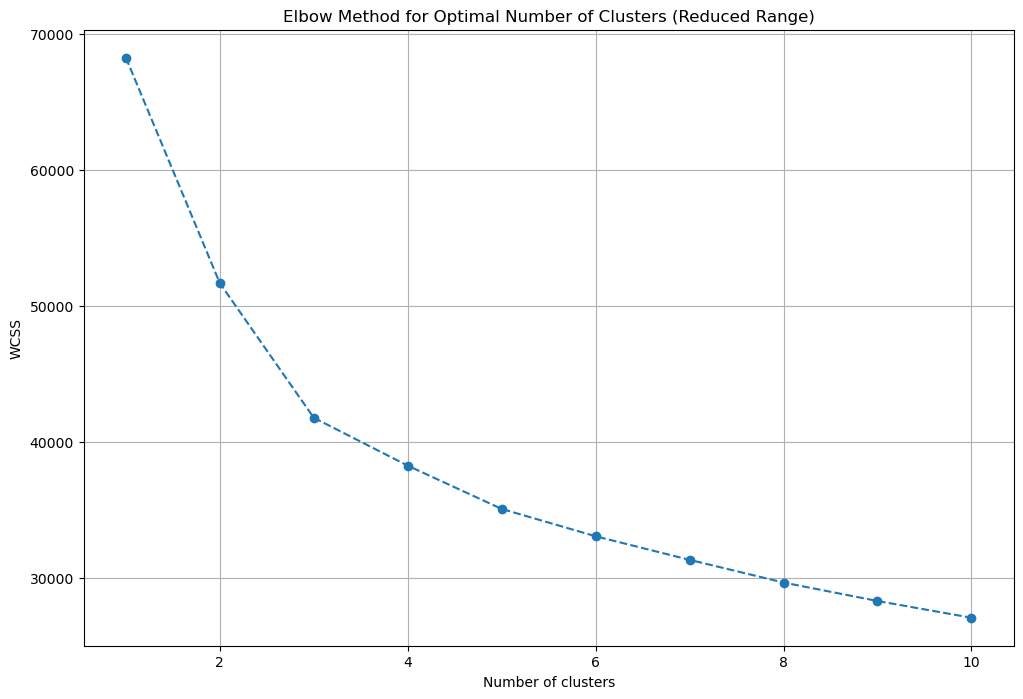

In [74]:
# plotting the results for better visualization
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [75]:
# from the above elbow we can see that the optimum number of clusters will be 3
n_clusters = 3

# fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

In [76]:
# removing the extra 'furnishings' columns

# checking the column locations
for i in df.columns:
    if i not in df.iloc[:, :-18].columns:
        print(i)

AC
Modular Kitchen
Fan
Sofa
Microwave
Bed
Dining Table
Curtains
Wardrobe
Water Purifier
Geyser
Stove
Washing Machine
Fridge
Exhaust Fan
Light
Chimney
TV


In [77]:
# assign a dataframe for the selected columns 
df = df.iloc[:, :-18]

In [78]:
# assigning the clusters assigned to 'furnishing_type' column
df['furnishing_type'] = cluster_assignments

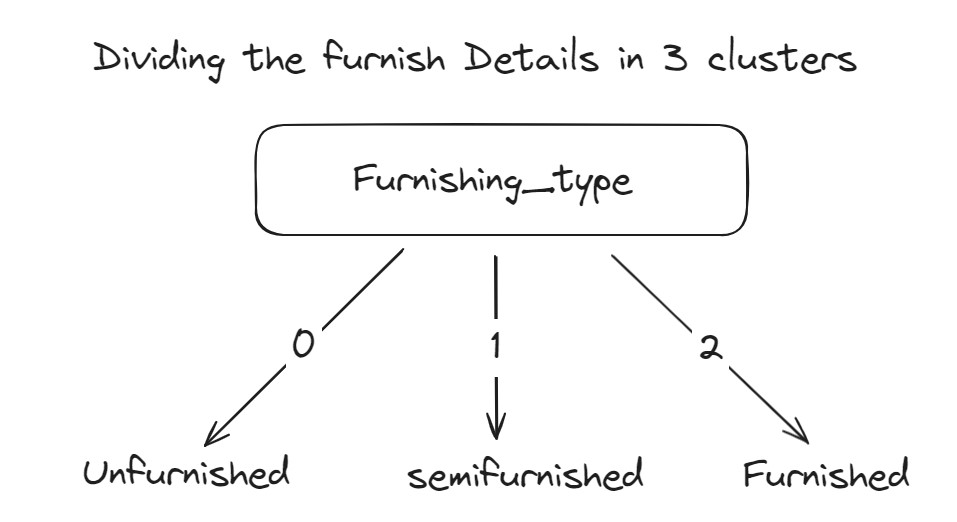

In [79]:
# path for the image
docs_imgs = home_dir / 'docs/imgs'
img_file = docs_imgs / 'furnishing_clusters.jpg'

display(Image(filename=img_file, embed=True, width=500, height=800))

In [80]:
# setting the seed value
np.random.seed(42)

# checking each row from each condition
pd.concat([
    df[df['furnishing_type']==0][['furnishDetails', 'furnishing_type']].sample(1),
    df[df['furnishing_type']==1][['furnishDetails', 'furnishing_type']].sample(1),
    df[df['furnishing_type']==2][['furnishDetails', 'furnishing_type']].sample(1),
    ])

,furnishDetails,furnishing_type
3486,"['5 Wardrobe', '8 Fan', '1 Exhaust Fan', '5 Geyser', '16 Light', '1 Modular Kitchen', '1 Chimney', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",0
101,"['1 Water Purifier', '3 Fan', '1 Fridge', '1 Exhaust Fan', '1 Dining Table', '1 Geyser', '1 Stove', '1 Light', '1 AC', '1 Chimney', '1 Curtains', '1 Modular Kitchen', '1 TV', '1 Wardrobe', '1 Sofa', '1 Microwave', '1 Washing Machine', 'No Bed']",1
2906,NaN,2


### 5.features

In [81]:
# checking few rows
df[['features']].sample(5)

,features
2850,"['Private Garden / Terrace', 'Maintenance Staff']"
3159,NaN
2751,"['Lift(s)', 'Park']"
1239,"['Security / Fire Alarm', 'Power Back-up', 'Feng Shui / Vaastu Compliant', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'Water Storage', 'No open drainage around', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
1730,"['Security / Fire Alarm', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'Water purifier', 'Maintenance Staff', 'Water Storage', 'Park', 'Piped-gas', 'Visitor Parking', 'Fitness Centre / GYM']"


In [82]:
# checking null values
print(f"Missing values in 'features' column: {df['features'].isnull().sum()}")

Missing values in 'features' column: 631


In [83]:
# as we can see in above cell, 'features' has many missing values
# we can fill these values from another dataset, 'appratment' dataset

In [84]:
raw_dir = data_dir / 'raw' # raw directory path
appartments_file = raw_dir / "appartments.csv" # appartments.csv file path

# reading the dataset with pandas
app_df = pd.read_csv(appartments_file)

# checking first two rows of the dataset
app_df.head(2)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Smartworld One DXP,"2, 3, 4 BHK Apartment in Sector 113, Gurgaon","['Bajghera Road', 'Palam Vihar Halt', 'DPSG Palam Vihar', 'Park Hospital', 'Gurgaon Railway Station']","{'Bajghera Road': '800 Meter', 'Palam Vihar Halt': '2.5 KM', 'DPSG Palam Vihar': '3.1 KM', 'Park Hospital': '3.1 KM', 'Gurgaon Railway Station': '4.9 KM', 'The NorthCap University': '5.4 KM', 'Dwarka Expy': '1.2 KM', 'Hyatt Place Gurgaon Udyog Vihar': '7.7 KM', 'Dwarka Sector 21, Metro Station': '7.2 KM', 'Pacific D21 Mall': '7.4 KM', 'Indira Gandhi International Airport': '14.7 KM', 'Hamoni Golf Camp': '6.2 KM', 'Fun N Food Waterpark': '8.8 KM', 'Accenture DDC5': '9 KM'}",https://www.99acres.com/smartworld-one-dxp-sector-113-gurgaon-npxid-r400415,"{'2 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,370 sq.ft.', 'price-range': '₹ 2 - 2.4 Cr'}, '3 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,850 - 2,050 sq.ft.', 'price-range': '₹ 2.25 - 3.59 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '2,600 sq.ft.', 'price-range': '₹ 3.24 - 4.56 Cr'}}","['Swimming Pool', 'Salon', 'Restaurant', 'Spa', 'Cafeteria', 'Sun Deck', '24x7 Security', 'Club House', 'Gated Community']"
1,M3M Crown,"3, 4 BHK Apartment in Sector 111, Gurgaon","['DPSG Palam Vihar Gurugram', 'The NorthCap University', 'Park Hospital, Palam Vihar', 'Pacific D21 Mall', 'Palam Vihar Halt Railway Station']","{'DPSG Palam Vihar Gurugram': '1.4 Km', 'The NorthCap University': '4.4 Km', 'Park Hospital, Palam Vihar': '1.4 Km', 'Pacific D21 Mall': '8.2 Km', 'Palam Vihar Halt Railway Station': '1.2 Km', 'Dwarka Sector 21 Metro Station': '8.1 Km', 'Dwarka Expressway': '450 m', 'Fun N Food Water Park': '8.1 Km', 'Indira Gandhi International Airport': '14.1 Km', 'Tau DeviLal Sports Complex': '11.2 Km', 'Hamoni Golf Camp': '5 Km', 'Hyatt Place': '6.1 Km', 'Altrade Business Centre': '11.2 Km'}",https://www.99acres.com/m3m-crown-sector-111-gurgaon-npxid-r404068,"{'3 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '1,605 - 2,170 sq.ft.', 'price-range': '₹ 2.2 - 3.03 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '2,248 - 2,670 sq.ft.', 'price-range': '₹ 3.08 - 3.73 Cr'}}","['Bowling Alley', 'Mini Theatre', 'Manicured Garden', 'Swimming Pool', 'Flower Garden', 'Reading Lounge', 'Golf Course', 'Barbecue', 'Sauna']"


In [85]:
# shape of the appartment dataset
print(f"appartment dataset shape: {app_df.shape}")

appartment dataset shape: (247, 7)


In [86]:
# columns in the dataset
app_df.columns

Index(['PropertyName', 'PropertySubName', 'NearbyLocations',
       'LocationAdvantages', 'Link', 'PriceDetails', 'TopFacilities'],
      dtype='object')

In [87]:
# lowering the text in 'PropertyName' column
app_df['PropertyName'] = app_df['PropertyName'].str.lower()

In [88]:
# creating a temporary df, which will hold the rows with missing values in 'feature' column
temp_df = df[df['features'].isnull()]

In [89]:
# shape of the temporary dataframe
temp_df.shape

(631, 26)

In [90]:
# merging the dataset on 'society' columnm 
x = temp_df.merge(app_df, left_on='society', right_on='PropertyName', how='left')['TopFacilities']

In [91]:
# assigning the values of 'x' to 'features' column
df.loc[temp_df.index, 'features'] = x.values

In [92]:
# chekcing the missing values after mergin the data
df['features'].isnull().sum()

477

In [93]:
# Convert the string representation of lists in the 'features' column to actual lists
df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df['features_list'])

# convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [94]:
# checking few rows
features_binary_df.head()

,24/7 Power Backup,24/7 Water Supply,24x7 Security,ATM,Aerobics Centre,Air Hockey,Airy Rooms,Amphitheatre,Automated Car Wash,Badminton Court,Bank Attached Property,Banquet Hall,Bar/Chill-Out Lounge,Barbecue,Basketball Court,Beach Volley Ball Court,Billiards,Bowling Alley,Bus Shelter,Business Lounge,CCTV Camera Security,Cafeteria,Car Parking,Car wash area,Card Room,Centrally Air Conditioned,Changing Area,Children's Play Area,Cigar Lounge,Clinic,Club House,Club house / Community Center,Community Hall,Concierge Service,Conference room,Creche/Day care,Cricket Pitch,Doctor on Call,Earthquake Resistant,Entrance Lobby,False Ceiling Lighting,Feng Shui / Vaastu Compliant,Fire Fighting Systems,Fitness Centre / GYM,Flower Garden,Food Court,Foosball,Football,Fountain,Gated Community,Gazebo,Golf Course,Grocery Shop,Gymnasium,High Ceiling Height,High Speed Elevators,Infinity Pool,Intercom Facility,Internal Street Lights,Internet/wi-fi connectivity,Jacuzzi,Jogging Track,Landscape Garden,Laundry,Lawn Tennis Court,Library,Lift(s),Lounge,Low Density Society,Maintenance Staff,Manicured Garden,Medical Centre,Milk Booth,Mini Theatre,Multipurpose Court,Multipurpose Hall,Natural Light,Natural Pond,No open drainage around,Park,Party Lawn,Pergola,Piped Gas,Piped-gas,Pool Table,Power Back up Lift,Power Back-up,Private Garden / Terrace,Property Staff,RO System,Rain Water Harvesting,Reading Lounge,Recently Renovated,Reflexology Park,Restaurant,Salon,Sauna,School,Security / Fire Alarm,Security Personnel,Separate entry for servant room,Sewage Treatment Plant,Shopping Centre,Skating Rink,Solar Lighting,Solar Water Heating,Spa,Spacious Interiors,Squash Court,Steam Room,Sun Deck,Swimming Pool,Temple,Terrace Garden,Theatre,Toddler Pool,Valet Parking,Vastu Compliant,Video Door Security,Visitor Parking,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Softener Plant,Water Storage,Water purifier,Water softening plant,Wi-Fi Connectivity,Yoga/Meditation Area
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0


In [95]:
# checking the shape
features_binary_df.shape

(3793, 130)

In [96]:
# Initialize an empty list to store the Within-Cluster Sum of squares (WCSS) values for different cluster numbers
wcss_reduced = []

# Iterate through different cluster numbers from 1 to 10
for i in tqdm(range(1, 11)):
    
    # Create a KMeans model with the current cluster number
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42) # k-means++ for better initialization
    
    # fit the model to the scaled data
    kmeans.fit(features_binary_df)
    
    # append the model's inertia (WCSS) to the list
    wcss_reduced.append(kmeans.inertia_)

  0%|          | 0/10 [00:00<?, ?it/s]

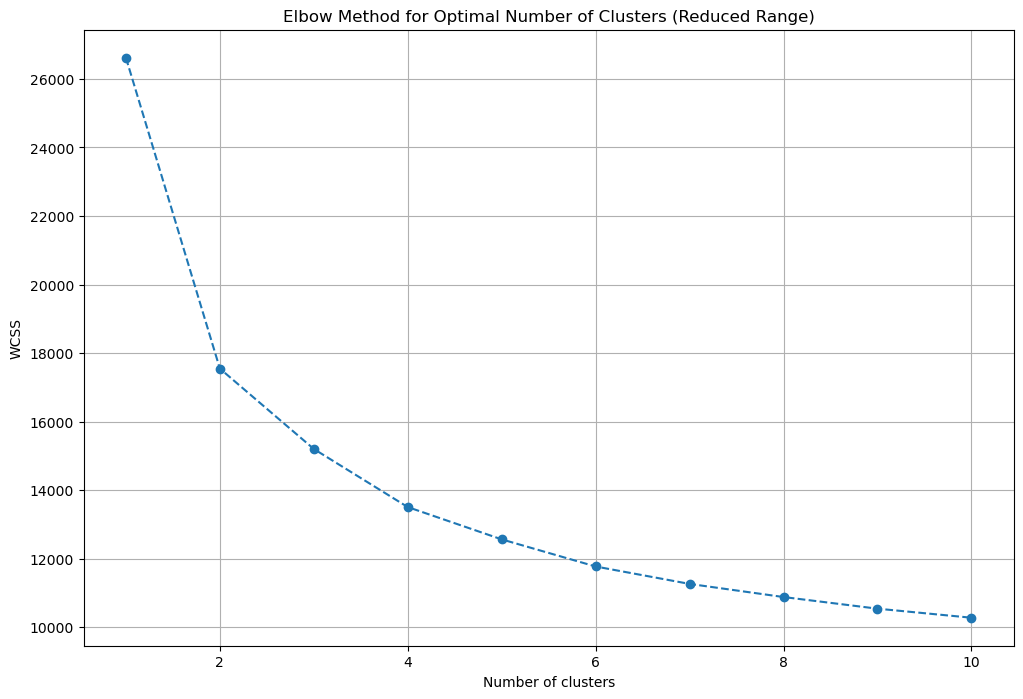

In [97]:
# plotting the results for better visualization
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [98]:
# Based on the above graph, it appears challenging to effectively capture the information
# contained within the "features" column solely through clustering.
# Therefore, we will explore an alternative approach: assigning weights to individual features based on their luxury level.
# This approach aims to capture the relative importance of each feature in determining the overall luxury perception.

In [99]:
# Assigning weights based on perceived luxury contribution

weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    'Bowling Alley': 8,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}

# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)

In [100]:
# add luxury score into the dataframe
df['luxury_score'] = luxury_score

In [101]:
# checking few rows from the dataset
df.head(2)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,servant room,others,pooja room,study room,store room,furnishing_type,features_list,luxury_score
0,flat,umang monsoon breeze,sector 78,0.95,5491.0,1730.0,Built Up area: 1730 (160.72 sq.m.),3.0,3,2,not available,9.0,East,Relatively New,"['Proposed Metro Station', 'Mahapal Shing', 'National Highway 8', 'IGD Primary Health Care', 'HDFC Bank', 'PCL Logistics', 'JW Mariott']","['3 Fan', '1 Exhaust Fan', '2 Geyser', '7 Light', '1 Chimney', '1 Modular Kitchen', '3 Wardrobe', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Swimming Pool', 'Park', 'Security Personnel', 'Internet/wi-fi connectivity', 'Fitness Centre / GYM', 'Club house / Community Center', 'Rain Water Harvesting']",NaN,1730.00,NaN,0,0,0,0,0,0,"[Feng Shui / Vaastu Compliant, Intercom Facility, Lift(s), Maintenance Staff, Swimming Pool, Park, Security Personnel, Internet/wi-fi connectivity, Fitness Centre / GYM, Club house / Community Center, Rain Water Harvesting]",65
1,flat,experion the heartsong,sector 108,1.68,8387.0,2003.0,Super Built up area 2003(186.08 sq.m.)Built Up area: 1338.29 sq.ft. (124.33 sq.m.)Carpet area: 986.41 sq.ft. (91.64 sq.m.),3.0,3,3+,"servant room,study room",4.0,East,Relatively New,"['Galleria 108 Mall', 'Dwarka Expressway', 'Central Peripheral Road', 'The Shikshiyan School', 'Manipal Hospital', 'Indira Gandhi International Airport', 'Vivanta New Delhi, Dwarka', 'SkyJumper Trampoline Park', 'Fun N Food Village']","['3 Wardrobe', '6 Fan', '1 Exhaust Fan', '1 Geyser', '7 Light', '5 AC', '1 Modular Kitchen', '1 Chimney', '1 Curtains', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Security / Fire Alarm', 'Power Back-up', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Visitor Parking', 'Swimming Pool', 'Park', 'Low Density Society', 'Shopping Centre', 'Fitness Centre / GYM', 'Rain Water Harvesting', 'Club house / Community Center', 'Water softening plant']",2003.0,1338.29,986.41,1,0,0,1,0,0,"[Security / Fire Alarm, Power Back-up, Feng Shui / Vaastu Compliant, Intercom Facility, Lift(s), Maintenance Staff, Water Storage, Visitor Parking, Swimming Pool, Park, Low Density Society, Shopping Centre, Fitness Centre / GYM, Rain Water Harvesting, Club house / Community Center, Water softening plant]",86


In [102]:
# we will delete the columns from which we have extracted the data(information) 
# and the columns which will not help us in further analysis

df.drop(columns=['nearbyLocations', 'furnishDetails', 'features', 'features_list', 'additionalRoom'], inplace=True)

In [103]:
# checking few samples from the dataframe
df.sample(5)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,servant room,others,pooja room,study room,store room,furnishing_type,luxury_score
107,flat,raheja teachers apartments,sector 31,1.20,7272.0,1650.0,Super Built up area 1650(153.29 sq.m.)Built Up area: 1450 sq.ft. (134.71 sq.m.)Carpet area: 1150 sq.ft. (106.84 sq.m.),3.0,2,2,1.0,East,Moderately New,1650.0,1450.0,1150.0,0,1,0,0,0,1,105
15,flat,vipul lavanya,sector 81,0.64,5261.0,1216.0,Carpet area: 1225 (113.81 sq.m.),2.0,2,3,12.0,East,Relatively New,NaN,NaN,1225.0,0,0,0,0,0,0,93
1868,flat,m3m ikonic,sector 68,1.80,9230.0,1950.0,Super Built up area 1950(181.16 sq.m.)Built Up area: 1845 sq.ft. (171.41 sq.m.)Carpet area: 1530 sq.ft. (142.14 sq.m.),3.0,3,3+,18.0,North-East,Relatively New,1950.0,1845.0,1530.0,0,0,0,0,0,0,126
1207,flat,chd avenue,sector 71,1.12,6215.0,1802.0,Super Built up area 1802(167.41 sq.m.),3.0,4,3,0.0,South-East,Moderately New,1802.0,NaN,NaN,1,0,0,0,0,2,65
3115,house,unitech uniworld resorts,sector 33,9.55,19293.0,4950.0,Plot area 550(459.87 sq.m.),6.0,7,3+,2.0,East,Relatively New,NaN,4950.0,NaN,1,0,1,1,1,0,126


In [104]:
# shape of the dataset
df.shape

(3793, 23)

In [105]:
# saving the dataset
interim_dir = data_dir / 'interim'
file_name = interim_dir / 'flat-house-dataset_v2.csv'

df.to_csv(file_name, index=False)